## Clasificación de sentimientos en comentarios de IMDB usando SVM y Logistic Regression


*Autor: Natalia Romero*



---

## Introducción:

IMDB es una de las bases de datos más grandes en internet que almacena información acerca de películas. Dada su alta popularidad, son miles los usuarios y críticos que hacen reseñas de las películas en dicha plataforma.

Con lo anterior, se tiene que las personas pueden emitir comentarios tanto buenos como malos, es por esto que el presente trabajo tiene como objetivo clasificar comentarios en base a sentimientos negativos y positivos, en base al datast atulanandjha/imdb-50k-movie-reviews-test-your-bert (disponible en kaggle), este dataset contiene 50.000 registros (25.000 para train y test)

Se hará uso de los algoritmos SVM y Logistic Regression para llevar a cabo las clasificaciones y se analizará su rendimiento en base a métricas de error.

---

### Instalación de librerías relevantes

In [1]:
import matplotlib.pyplot as plt
import pylab as pl                         
import pandas as pd 
import numpy as np 
from seaborn import scatterplot

### Instalación de scikit-learn
Se usará esta librería para el uso de los algoritmos

In [2]:
!pip install -U scikit-learn

from sklearn import svm
from sklearn.svm import LinearSVC 
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Instalación kaggle

Importar kaggle.json

In [3]:
from google.colab import files 
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [4]:
!pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json 

Descarga y extracción de dataset

In [5]:
! kaggle datasets download -d atulanandjha/imdb-50k-movie-reviews-test-your-bert

 27% 7.00M/25.7M [00:00<00:00, 70.3MB/s]
100% 25.7M/25.7M [00:00<00:00, 155MB/s] 


In [6]:
!unzip /content/imdb-50k-movie-reviews-test-your-bert.zip #extraccion del archivo .csv 

Archive:  /content/imdb-50k-movie-reviews-test-your-bert.zip
  inflating: test.csv                
  inflating: train.csv               


### Dataset
Se tienen dos dataset (train y test) por lo que se cumple con un (sub)conjunto disjunto ya que los datos de entrenamiento y prueba están separados

Lectura del dataset de entrenamiento y prueba

In [7]:
train = pd.read_csv('train.csv') 
train.head()

,text,sentiment
0,"Now, I won't deny that when I purchased this o...",neg
1,"The saddest thing about this ""tribute"" is that...",neg
2,Last night I decided to watch the prequel or s...,neg
3,I have to admit that i liked the first half of...,neg
4,I was not impressed about this film especially...,neg


In [8]:
test = pd.read_csv('test.csv') 
test.head()

,text,sentiment
0,"My daughter liked it but I was aghast, that a ...",neg
1,I... No words. No words can describe this. I w...,neg
2,this film is basically a poor take on the old ...,neg
3,"This is a terrible movie, and I'm not even sur...",neg
4,First of all this movie is a piece of reality ...,pos


Tamaño de los datasets

In [9]:
print('train: ',train.shape)

train:  (25000, 2)


In [10]:
print('test: ',test.shape)

test:  (25000, 2)


Distribución de los sentimientos (positivo y negativo)

In [11]:
train['sentiment'].value_counts()

neg    12500
pos    12500
Name: sentiment, dtype: int64

<Axes: title={'center': 'Distribución de sentimientos [TRAIN]'}, ylabel='sentiment'>

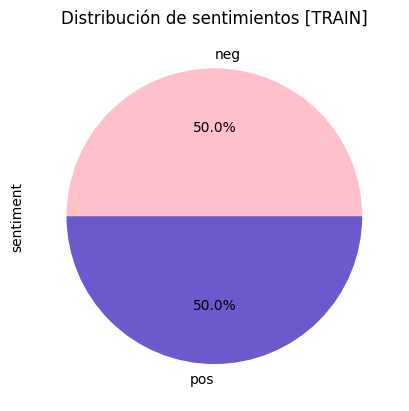

In [12]:
train['sentiment'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['pink','slateblue'],title='Distribución de sentimientos [TRAIN]')

In [13]:
test['sentiment'].value_counts()

neg    12500
pos    12500
Name: sentiment, dtype: int64

<Axes: title={'center': 'Distribución de sentimientos [TEST]'}, ylabel='sentiment'>

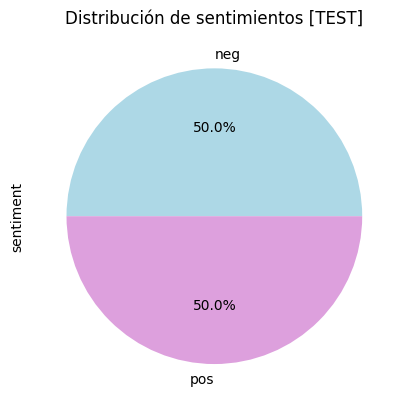

In [14]:
test['sentiment'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['lightblue','plum'],title='Distribución de sentimientos [TEST]')

Se puede apreciar que tanto como para los datos de entrenamiento y de prueba, las etiquetas están igualmente distribuidas.

### Modelamiento de los datos

División de datos por texto y sentimiento. Además se realizan técnicas de normalización de texto como dejar todo en minusculas y eliminar puntuaciones, esto para que no intervenga con el procesamiento.

In [15]:
train_x = train.drop('sentiment', axis=1)['text'].str.lower().str.replace(r'[^\w\s]', '')
train_y = train['sentiment']
test_x = test.drop('sentiment', axis=1)['text'].str.lower().str.replace(r'[^\w\s]', '')
test_y = test['sentiment']

<ipython-input-15-d1e0658b0b0d>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_x = train.drop('sentiment', axis=1)['text'].str.lower().str.replace(r'[^\w\s]', '')
<ipython-input-15-d1e0658b0b0d>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  test_x = test.drop('sentiment', axis=1)['text'].str.lower().str.replace(r'[^\w\s]', '')


Para la generación del modelo, los datos obtenidos, debido a que corresponden a strings se vectorizan para luego ser clasificados.


Para la vectorización de los textos se usa una función de extracción de texto de la librería SciKit la cual es TfidfVectorizer. 

Este tipo de técnica permite convertir el texto en matrices númericas. Sus siglas son "Term Frequency-Inverse Document Frequency", lo cual quiere decir que asigna puntuaciones a las palabras del texto en función de su relevancia en el texto. 

Para las etiquetas se usa la técnica LabelEncoder, la cual sirve para pasar las categorías a valores númericos.

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

vectorizer_x = TfidfVectorizer()
vectorizer_y = LabelEncoder()

In [17]:
X_train = vectorizer_x.fit_transform(train_x)
y_train =  vectorizer_y.fit_transform(train_y)
X_test =  vectorizer_x.transform(test_x)
y_test =  vectorizer_y.transform(test_y)

### Implementación SVM

Para la implementación del modelo SVM, se usa el metódo LinearSVC de SciKit Learn. Típicamente se utiliza el metódo SVC, pero las diferencias radican en el kernel a utilizar, SVC puede utilizar distintos tipos de kernel (lineal, RBF, polinómico, etc), en cambio, LinearSVC se enfoca en un kernel lineal y tiende a ser más rápido que SVC, por lo que debido a la gran cantidad de datos a utilizar se opta por usar este metódo. 

_Documentación: https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html_

Este modelo encuentra la mejor línea para separar datos en diferentes grupos (sentimientos negativos o positivos)

A continuación, se genera el modelo SVM con los siguientes parametros:
- verbose=True: Muestra información adicional durante el entrenamiento del
modelo.
- loss="hinge": Utiliza la función de pérdida de bisagra para entrenar el modelo.
- max_iter=100000: Establece el número máximo de iteraciones para el entrenamiento del modelo antes de detenerse.

In [18]:
svc = LinearSVC(verbose = True, loss="hinge",  max_iter=100000)
svc.fit(X_train, y_train)

[LibLinear]

LinearSVC(loss='hinge', max_iter=100000, verbose=True)

In [19]:
y_pred_s = svc.predict(X_test)
score = svc.score(X_test,y_test)
print('Puntuación: ',score)

Puntuación:  0.88564


### Implementación Logistic Regression

Para la implementación de Logistic Regression, se utiliza el metódo LogisticRegression de SciKit Learn. 


Este modelo utiliza una función sigmoide para modelar la probabilidad de pertenecer a una categoría determinada en función de las características de entrada. En este caso las categorías son los sentimientos y las entradas los comentarios (texto)

A continuación, se genera el modelo Logistic Regression con los siguientes parametros:
- verbose=True: Muestra información adicional durante el entrenamiento del modelo.
-  max_iter=100000: Establece el número máximo de iteraciones para el entrenamiento del modelo antes de detenerse.

In [20]:
logistic_regression = LogisticRegression(verbose = True,max_iter=100000)
logistic_regression.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.6s finished


LogisticRegression(max_iter=100000, verbose=True)

In [21]:
y_pred_l = logistic_regression.predict(X_test)
score = logistic_regression.score(X_test,y_test)
print('Puntuación: ',score)

Puntuación:  0.88308


### Métricas de error

Para los dos modelos se analizaran distintas métricas de error. Estas métricas nos ayudan a evaluar el desempeño de las predicciones realizadas. 

**Matriz de confusión**


En primer lugar se analizará la matriz de confusión para ambos casos. Esta tabla es muy importante ya que permite evaluar donde el modelo tuvo errores. Se tienen los siguientes cuadrantes: 

- True Negative (Cuadrante Arriba-Izquierda):  La predicción negativa es verdadera.
- False Positive (Cuadrante Arriba-Derecha): La predicción positiva es falsa.
- False Negative (Cuadrante Abajo-Izquierda): La predicción negativa es falsa.
- True Positive (Cuadrante Abajo-Derecha): La predicción positiva es verdadera.

SVM:


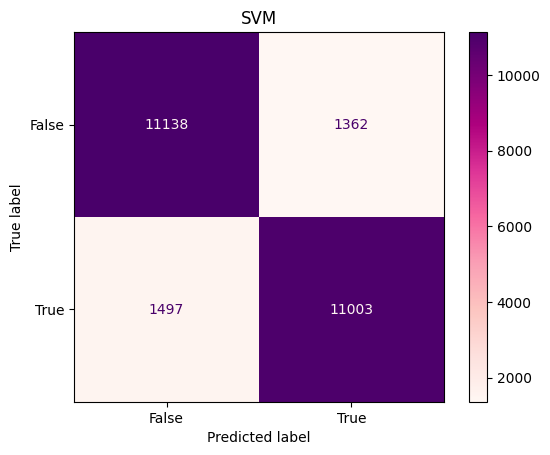

In [22]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_s)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot(cmap='RdPu') 
plt.title('SVM')
plt.show()

En base a la matriz, se puede extraer que se acertó a una mayor cantidad de predicciones a comentarios negativos que positivos (aunque en realidad la diferencia es muy mínima). Por parte de los errores, el modelo se equivocó más en los comentarios negativos que positivos (nuevamente es una diferencia muy mínima). Esto puede deberse a que tal vez los comentarios negativos tienen frases más "dominantes" que este tipo de modelo es más sensible.

Logistic Regression

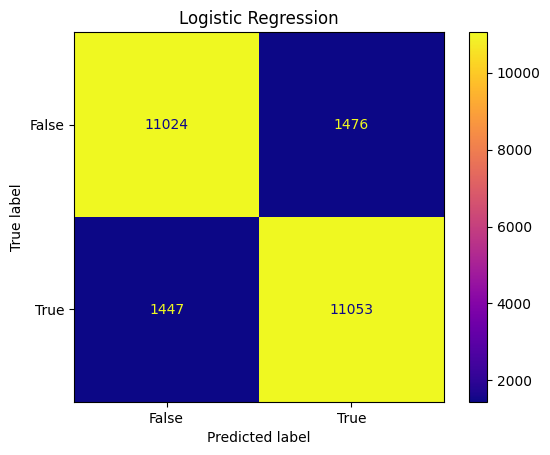

In [23]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_l)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot(cmap='plasma') 
plt.title('Logistic Regression')
plt.show()

En base a la matriz, se puede extraer que se acertó a una mayor cantidad de predicciones a comentarios positivos que negativos (aunque en realidad la diferencia es muy mínima). Por parte de los errores, el modelo se equivocó más en los comentarios positivos que negativos (nuevamente es una diferencia muy mínima). Esto puede decir que tal vez, a diferencia de SVM, los comentarios poaitivos tienen frases más "dominantes" que este tipo de modelo es más sensible.

Para ambos modelos en base a la matriz de confusión, se puede decir que tuvieron una presición bastante alta. En los modelos se obtuvieron diferencias cargadas entre los comentarios negativos y positivos. Estas diferencias pueden ser resultado de las características específicas de los modelos y de la naturaleza del conjunto de datos utilizado.

**Accuracy**


In [24]:
data = {
    'Model': ['SVM', 'Logistic Regression'],
    'Accuracy': [metrics.accuracy_score(y_test, y_pred_s), metrics.accuracy_score(y_test, y_pred_l)]
}
df = pd.DataFrame(data)
df

,Model,Accuracy
0,SVM,0.88564
1,Logistic Regression,0.88308


Esta métrica de error permite calcular la puntuación de precisión para un conjunto de etiquetas predecidas contra las etiquetas verdaderas. En este caso se tiene que el modelo **SVM** tiene menos error que **Logistic Regression** 
donde se tiene una diferencia muy baja, esto se puede deber a la estructura de los modelos, la sensibilidad que tienen los modelos frente a los datos, etc.


Por lo tanto, el 88,5% de las veces el modelo SVM predicirá con exactitud los datos. Por otro lado, el 88,3% de las veces el modelo Logistic Regression predicirá con exactitud los datos.

**Precision**

In [25]:
data = {
    'Model': ['SVM', 'Logistic Regression'],
    'Precision': [metrics.precision_score(y_test, y_pred_s), metrics.precision_score(y_test, y_pred_l)]
}
df = pd.DataFrame(data)
df

,Model,Precision
0,SVM,0.889850
1,Logistic Regression,0.882193


Esta métrica de error permite medir la proporción de etiquetas predecidas positivamente que en realidad son correctas. En este caso se tiene que el modelo **SVM** tiene menos error que **Logistic Regression** donde se tiene una diferencia muy pequeña, esto se puede deber a diversos factores como el ajuste de hiperparámetros, además cada modelo tiene distintos enfoque para las predicciones.


Por lo tanto, el 88,9% de las veces el modelo SVM predicirá con exactitud los datos positivos. Por otro lado, el 88,2% de las veces el modelo Logistic Regression predicirá con exactitud los datos positivos.